In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


# VAH## 파일이 들어있는 폴더
DATA_DIR = r"D:\eVTOL dataset\ML project"

# 파일명
vah_list = [
    "VAH01","VAH02","VAH06","VAH07","VAH09","VAH10","VAH11","VAH12","VAH13",
    "VAH15","VAH16","VAH17","VAH20","VAH22","VAH24","VAH25","VAH26","VAH27","VAH28","VAH30"
]

# column명
t_col     = "time_s"
v_col     = "Ecell_V"
i_col     = "I_mA"
temp_col  = "Temperature__C"
cycle_col = "new_cycle"
valid_col = "valid_cycle"
rpt_col   = "RPT_cycle"
soc_col   = "SOC_shifted"

# --------------------------------------------------
# 1. 전체 파일 읽기
    # 여러개의 파일을 이어 붙이고 표시함. 
def load_cells(data_dir, cell_names):
    dfs = []
    for cell in cell_names:
        fp = os.path.join(data_dir, f"{cell}.csv")
        d = pd.read_csv(fp)
        d["cell_id"] = cell
        dfs.append(d)
    return pd.concat(dfs, ignore_index=True)

df = load_cells(DATA_DIR, vah_list)


# --------------------------------------------------
# 2. SOC 추정 사이클과 구간 마킹

mask = (
    (df[valid_col] == True) &
    (df[rpt_col] == False) &
    (df[i_col] < 0)
)

use_cols = ["cell_id", cycle_col, t_col, v_col, i_col, temp_col, soc_col]
dfd = df.loc[mask, use_cols].copy()
dfd = dfd.dropna(subset=use_cols)
dfd = dfd.sort_values(["cell_id", cycle_col, t_col])

# --------------------------------------------------------------
# 3. SOC cliping

dfd[soc_col] = dfd[soc_col].astype(float).clip(0.0, 1.0)



# ------------------------------------------------------
# 4. cycle number 재설정 

pairs = (
    dfd[["cell_id", cycle_col]]
    .drop_duplicates()
    .sort_values(["cell_id", cycle_col])
)
pairs["cycle_ml"] = pairs.groupby("cell_id").cumcount() + 1

dfd = dfd.merge(pairs, on=["cell_id", cycle_col], how="left")
dfd = dfd.sort_values(["cell_id", "cycle_ml", t_col]).reset_index(drop=True)


# ---------------------------------------------------------
# 5. 중복된 측정 제거
    # 시간 중복된 측정이 있으면 dt=0이 생기기 때문에 dV/dt가 0이 될 수 있음. 
    # 따라서 중복된 측정이 있다면 제거. 

dfd = dfd.drop_duplicates(subset=["cell_id", "cycle_ml", t_col], keep="first")



# ---------------------------------------------------------
# 6. dV/dt를 고려한다. 

grp = dfd.groupby(["cell_id", "cycle_ml"], sort=False)

dfd["dt"] = grp[t_col].diff()
dfd["dV"] = grp[v_col].diff()

# dt==0 방지
dfd["dt"] = dfd["dt"].replace(0, np.nan)

dfd["dVdt"] = dfd["dV"] / dfd["dt"]

# inf/NaN 처리: 각 cycle 첫 행은 NaN이므로 0으로
dfd["dVdt"] = dfd["dVdt"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
dfd["dt"]   = dfd["dt"].fillna(0.0)

# outlier가 처리
dVdt_clip = 0.05  # V/s
dt_clip   = 60.0  # s
dfd["dVdt"] = dfd["dVdt"].clip(-dVdt_clip, dVdt_clip)
dfd["dt"]   = dfd["dt"].clip(0.0, dt_clip)


# --------------------------------------------------
# 7. basic model과 동이랗게 train/test 데이터 설정

all_cells = sorted(dfd["cell_id"].unique())
rng = np.random.RandomState(42)

n_test = max(1, int(round(0.2 * len(all_cells))))  # 20개면 보통 4개
test_cells = sorted(rng.choice(all_cells, size=n_test, replace=False))
train_cells = [c for c in all_cells if c not in test_cells]

train_df = dfd.loc[dfd["cell_id"].isin(train_cells)].copy()
test_df  = dfd.loc[dfd["cell_id"].isin(test_cells)].copy()

print("Train cells:", train_cells)
print("Test cells :", test_cells)
print("Train rows :", len(train_df), " Test rows:", len(test_df))


# ----------------------------------------------------
# 8. 모델 학습
    # 입력 변수로 전압, 전류, 온도, dV/dt, dt를 사용한다. 

feat_cols = [v_col, i_col, temp_col, "dVdt", "dt"]

X_train = train_df[feat_cols].to_numpy(dtype=float)
y_train = train_df[soc_col].to_numpy(dtype=float)

X_test  = test_df[feat_cols].to_numpy(dtype=float)
y_test  = test_df[soc_col].to_numpy(dtype=float)

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=3
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test MAE  = {mae:.5f}")
print(f"Test RMSE = {rmse:.5f}")


# -------------------------------------------
# 9. 셀 별 MAE

test_df = test_df.copy()
test_df["pred"] = y_pred

cell_mae = (
    test_df.groupby("cell_id")
           .apply(lambda g: mean_absolute_error(g[soc_col].to_numpy(), g["pred"].to_numpy()))
           .sort_values()
)

print("\nMAE by test cell:")
print(cell_mae)


Train cells: ['VAH06', 'VAH07', 'VAH09', 'VAH10', 'VAH11', 'VAH12', 'VAH13', 'VAH15', 'VAH16', 'VAH17', 'VAH20', 'VAH22', 'VAH24', 'VAH26', 'VAH28', 'VAH30']
Test cells : ['VAH01', 'VAH02', 'VAH25', 'VAH27']
Train rows : 1526379  Test rows: 892204
Test MAE  = 0.01910
Test RMSE = 0.03401

MAE by test cell:
cell_id
VAH25    0.007937
VAH27    0.008076
VAH02    0.019821
VAH01    0.021642
dtype: float64


C:\Users\zzxcv\AppData\Local\Temp\ipykernel_19748\1019151860.py:153: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mean_absolute_error(g[soc_col].to_numpy(), g["pred"].to_numpy()))


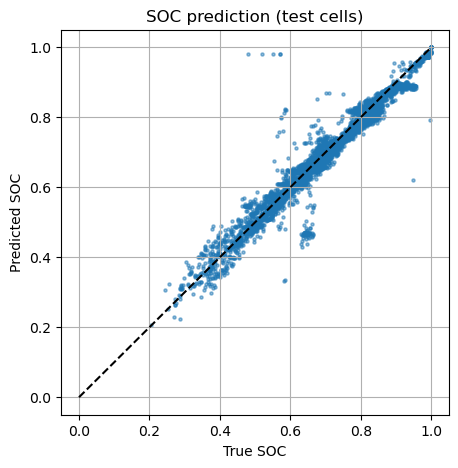

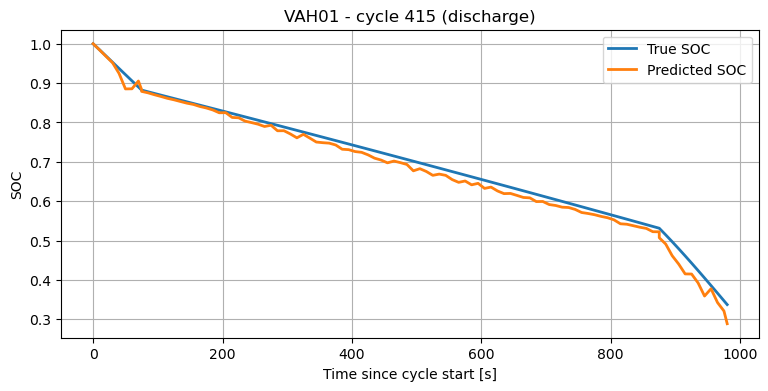

In [ ]:
# 산점도 plot
n_plot = min(5000, len(test_df))
rng = np.random.RandomState(0)
idx = rng.choice(len(test_df), size=n_plot, replace=False)

x_true = test_df[soc_col].iloc[idx].to_numpy(dtype=float)
x_pred = test_df["pred"].iloc[idx].to_numpy(dtype=float)

plt.figure(figsize=(5, 5))
plt.scatter(x_true, x_pred, s=5, alpha=0.5)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("True SOC")
plt.ylabel("Predicted SOC")
plt.title("SOC prediction (test cells)")
plt.grid(True)
plt.show()

# -------------------------------------------------
# 임의의 사이클에 대한 model voltage vs true voltage plot
cell = test_df["cell_id"].iloc[0]

# 해당 셀에서 cycle 목록
cell_cycles = np.sort(test_df.loc[test_df["cell_id"] == cell, "cycle_ml"].unique())
if len(cell_cycles) == 0:
    raise ValueError("No cycles found in the selected test cell.")

# 가운데 cycle 선택 (너무 극단 cycle 피하기)
cycle = cell_cycles[len(cell_cycles) // 2]

g = test_df[
    (test_df["cell_id"] == cell) &
    (test_df["cycle_ml"] == cycle)
].sort_values(t_col)

if len(g) < 5:
    raise ValueError("Selected cycle has too few points to plot.")

t0 = g[t_col].iloc[0]
t_shift = (g[t_col] - t0).to_numpy(dtype=float)

soc_true = g[soc_col].to_numpy(dtype=float)
soc_pred = g["pred"].to_numpy(dtype=float)

plt.figure(figsize=(9, 4))
plt.plot(t_shift, soc_true, label="True SOC", linewidth=2)
plt.plot(t_shift, soc_pred, label="Predicted SOC", linewidth=2)
plt.xlabel("Time since cycle start [s]")
plt.ylabel("SOC")
plt.title(f"{cell} - cycle {cycle} (discharge)")
plt.grid(True)
plt.legend()
plt.show()
